In [92]:
!pip install opencv-python numpy matplotlib

In [93]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

# Smart histogram descriptor

In [94]:
images = {}
for folder in os.listdir('img'):
    for file in os.listdir(f'img/{folder}'):
        images[f'{folder.replace(' ', '-')}-{file.replace('.jpg', '')}'] = cv.imread(f'img/{folder}/{file}', cv.IMREAD_COLOR)

In [95]:
def get_sub_images(image, size):
    sub_images = []
    for i in range(0, image.shape[0], size):
        for j in range(0, image.shape[1], size):
            sub_images.append(image[i:i+size, j:j+size])
    return sub_images

images_divided = {name: get_sub_images(image, 56) for name, image in images.items()}

In [96]:
images_divided_hist = {}
color = ('b','g','r')
for name, img in images_divided.items():
    hist = []
    for sub_img in img:
        histr = []
        for i, col in enumerate(color):
            histr.append(cv.calcHist([sub_img], [i], None, [256], [0, 256]))
        hist.append(histr)
    images_divided_hist[name] = hist

In [97]:
selected_img = 'three-of-hearts-1'

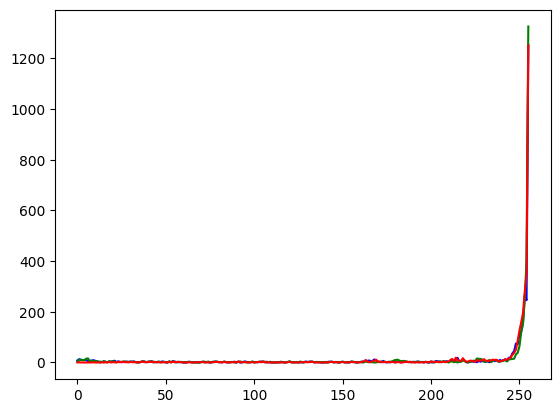

In [98]:
for i, col in enumerate(color):
    plt.plot(images_divided_hist[selected_img][0][i], color=col)
plt.show()

In [99]:
def calculate_distance_sub_img(sub_img1, sub_img2):
    distance = 0
    for i in range(3):
        distance += cv.compareHist(sub_img1[i], sub_img2[i], cv.HISTCMP_CHISQR)
    return distance / 3

In [100]:
def calculate_distance_img(img1, img2):
    distance = 0
    for i in range(len(img1)):
        distance += calculate_distance_sub_img(img1[i], img2[i])
    return distance / len(img1)

In [101]:
def calculate_distances_to_all_images(img, images):
    dist = {name: calculate_distance_img(img, img2) for name, img2 in images.items()}
    return dist

In [102]:
distances_hist = calculate_distances_to_all_images(images_divided_hist[selected_img], images_divided_hist)

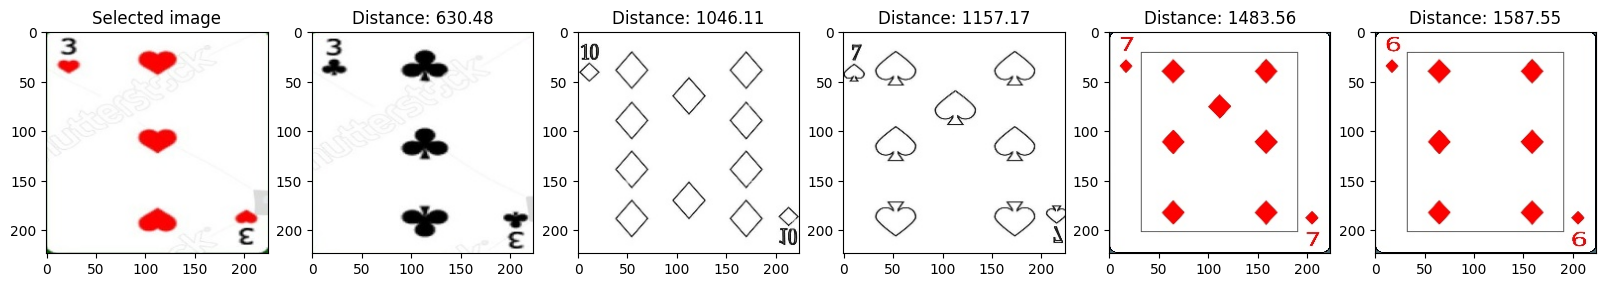

<Figure size 640x480 with 0 Axes>

In [103]:
# Plot with the 5 most similar images to the one we selected
fig, ax = plt.subplots(1, 6, figsize=(20, 5))
ax[0].imshow(cv.cvtColor(images[selected_img], cv.COLOR_BGR2RGB))
ax[0].set_title('Selected image')
ordered_hist_distances = sorted(distances_hist.items(), key=lambda x: x[1])
for i in range(1, 6):
    ax[i].imshow(cv.cvtColor(images[ordered_hist_distances[i][0]], cv.COLOR_BGR2RGB))
    ax[i].set_title(f'Distance: {ordered_hist_distances[i][1]:.2f}')
plt.show()
plt.clf()

# HOG descriptor


In [104]:
def harris_hog_descriptor(image):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # Harris Corner Detection
    harris_corners = cv.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
    harris_corners = cv.dilate(harris_corners, None)

    # HOG Descriptor
    hog = cv.HOGDescriptor((16, 16), (8, 8), (1, 1), (8, 8), 9)
    hog_descriptor = hog.compute(gray)

    return harris_corners, hog_descriptor

In [105]:
def calculate_distances_to_all_images_hog(image):
    reference_harris, reference_hog = harris_hog_descriptor(image)
    reference_descriptor = np.concatenate([reference_harris.flatten(), reference_hog.flatten()])
    
    dist = {}
    for name, img in images.items():
        other_harris, other_hog = harris_hog_descriptor(img)
        other_descriptor = np.concatenate([other_harris.flatten(), other_hog.flatten()])
        # Calculate euclidean distance
        dist[name] = np.linalg.norm(reference_descriptor - other_descriptor)
    
    return dist

distances_hog = calculate_distances_to_all_images_hog(images[selected_img])

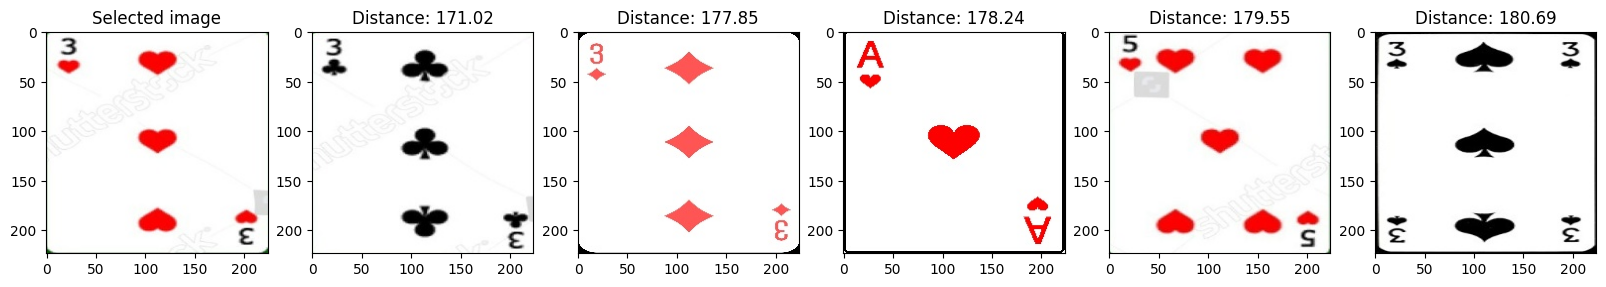

<Figure size 640x480 with 0 Axes>

In [106]:
# Plot with the 5 most similar images to the one we selected
fig, ax = plt.subplots(1, 6, figsize=(20, 5))
ax[0].imshow(cv.cvtColor(images[selected_img], cv.COLOR_BGR2RGB))
ax[0].set_title('Selected image')
ordered_hog_distances = sorted(distances_hog.items(), key=lambda x: x[1])
for i in range(1, 6):
    ax[i].imshow(cv.cvtColor(images[ordered_hog_distances[i][0]], cv.COLOR_BGR2RGB))
    ax[i].set_title(f'Distance: {ordered_hog_distances[i][1]:.2f}')
plt.show()
plt.clf()

# Combine both descriptors

In [107]:
normalized_hist_distances = {name: dist / ordered_hist_distances[-1][1]  for name, dist in distances_hist.items()}
normalized_hog_distances = {name: dist / ordered_hog_distances[-1][1] for name, dist in distances_hog.items()}

In [108]:
combined_distances = {}
hist_weight = 0.3
hog_weight = 1 - hist_weight
for name in images.keys():
    combined_distances[name] = (hist_weight * normalized_hist_distances[name] + hog_weight * normalized_hog_distances[name]) / 2

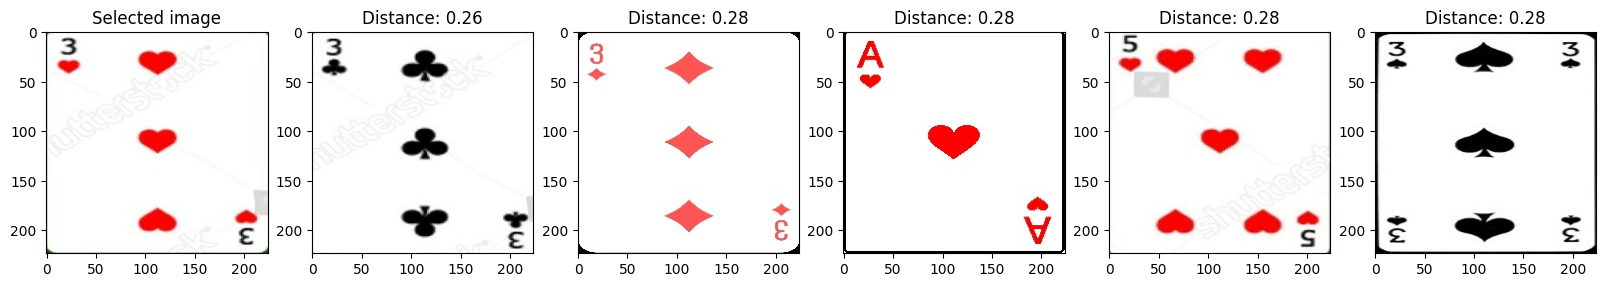

<Figure size 640x480 with 0 Axes>

In [109]:
# Plot with the 5 most similar images to the one we selected
fig, ax = plt.subplots(1, 6, figsize=(20, 5))
ax[0].imshow(cv.cvtColor(images[selected_img], cv.COLOR_BGR2RGB))
ax[0].set_title('Selected image')
ordered_combined_distances = sorted(combined_distances.items(), key=lambda x: x[1])
for i in range(1, 6):
    ax[i].imshow(cv.cvtColor(images[ordered_combined_distances[i][0]], cv.COLOR_BGR2RGB))
    ax[i].set_title(f'Distance: {ordered_combined_distances[i][1]:.2f}')
plt.show()
plt.clf()